In [23]:
import pandas as pd
import os
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.normalizers import NFD, StripAccents, Lowercase
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import re

In [5]:
# Directories
cwd= os.getcwd()
data_dir= cwd + "/data/"
artifacts_dir= cwd + "/artifacts/"

In [6]:
df= pd.read_csv(data_dir+"preprocessed_imdb_dataset.csv")
df['cleaned_review'].head(5)

,cleaned_review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is..."


In [20]:
# Text Preprocessing Utils
def clean_text(text):

    # Patterns to detect and replace
    urls= r'https?://\S+|www\.\S+'
    html_tags= r'<[^>]+>'
    # Punctuation Specific Patterns
    punct_repetition= r'(!|\?|\.){2,}'
    ellipsis= r'\.{3,}|\.\s*\.\s*\.|…'
    quotes= r'[“”]'
    apostrophes= r"[‘’]"
    hyphens= r'\b\d+-\d+\b'


    # Clean Text using Regex
    cleaned_text= text.lower()
    cleaned_text= re.sub(urls, ' ', cleaned_text)
    cleaned_text= re.sub(html_tags, ' ', cleaned_text)

    cleaned_text= re.sub(punct_repetition, r'\1', cleaned_text)
    cleaned_text= re.sub(ellipsis, '...', cleaned_text)
    cleaned_text= re.sub(quotes, r'"', cleaned_text)
    cleaned_text= re.sub(apostrophes, r"'", cleaned_text)
    cleaned_text= re.sub(hyphens, ' ', cleaned_text)

    # Removing Extra Spaces
    cleaned_text= re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text= cleaned_text.strip()

    return cleaned_text

In [7]:
def train_bpe_tokenizer(texts, vocab_size= 30000, min_frequency= 2):
    # Initialize a tokenizer
    tokenizer= Tokenizer(BPE(unk_token= '[UNK]'))
    # Add normalizers
    tokenizer.normalizer= normalizers.Sequence([NFD(), StripAccents(), Lowercase()])
    # Use whitespace pre-tokenization
    tokenizer.pre_tokenizer= Whitespace()
    special_tokens= ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    # Initialize trainer
    trainer= BpeTrainer(
        vocab_size= vocab_size,
        special_tokens= special_tokens,
        min_frequency= min_frequency,
        show_progress= True
    )

    # Train the tokenizer
    tokenizer.train_from_iterator(texts, trainer=trainer)

    cls_id= tokenizer.token_to_id("[CLS]")
    sep_id= tokenizer.token_to_id("[SEP]")

    if cls_id is not None and sep_id is not None:

        tokenizer.post_processor = TemplateProcessing(
            single="[CLS] $A [SEP]",
            pair="[CLS] $A [SEP] $B:1 [SEP]:1",
            special_tokens=[
                ("[CLS]", cls_id),
                ("[SEP]", sep_id),
            ],
        )
    else:
        print("Warning: [CLS] or [SEP] tokens not found in vocabulary")

    return tokenizer

In [8]:
# Split cleaned text
X_train, X_test, Y_train, Y_test= train_test_split(df['cleaned_review'], df['sentiment'], test_size= 0.2, random_state= 42, stratify= df['sentiment'])

# Train tokenizer
bpe_tokenizer= train_bpe_tokenizer(X_train)

# Save the tokenizer
bpe_tokenizer.save(artifacts_dir+"bpe_tokenizer.json")

# Get Vocab size for model init
vocab_size= bpe_tokenizer.get_vocab_size()
print(f"BPE Vocabulary size: {vocab_size}")

BPE Vocabulary size: 30000


In [9]:
class BPEDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length= 512):
        self.texts= texts
        self.labels= labels
        self.tokenizer= tokenizer
        self.max_length= max_length

    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):

        text= self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx]
        label= self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]
        sentiment= 1 if label == 'positive' else 0

        # Tokenize text
        encoding= self.tokenizer.encode(text)

        # Get token IDs and create atten mask
        input_ids= encoding.ids
        attention_mask= [1] * len(input_ids)

        # Truncate if necessary
        if len(input_ids) > self.max_length:
            input_ids= input_ids[:self.max_length]
            attention_mask= attention_mask[:self.max_length]
        # Pad if necessary
        padding_length= self.max_length - len(input_ids)
        if padding_length > 0:
            input_ids= input_ids + [self.tokenizer.token_to_id("[PAD]")] * padding_length
            attention_mask= attention_mask + [0] * padding_length

        return {
            'input_ids': torch.tensor(input_ids, dtype= torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype= torch.long),
            'labels': torch.tensor(sentiment, dtype= torch.long)
        }

In [10]:
# Creating datasets
train_texts= X_train.tolist()
train_labels= Y_train.tolist()
val_texts= X_test.tolist()
val_labels= Y_test.tolist()

train_dataset= BPEDataset(train_texts, train_labels, bpe_tokenizer)
val_dataset= BPEDataset(val_texts, val_labels, bpe_tokenizer)

In [11]:
def bpe_collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

In [12]:
train_dataset[4]['input_ids'].shape

torch.Size([512])

In [13]:
batch_size= 32
train_loader= DataLoader(
    train_dataset,
    batch_size= batch_size,
    shuffle= True,
    collate_fn= bpe_collate_fn
)
val_loader= DataLoader(
    val_dataset,
    batch_size= batch_size,
    shuffle= False,
    collate_fn= bpe_collate_fn
)
batch= next(iter(train_loader))
input_ids= batch['input_ids']
bpe_tokenizer.decode(input_ids[1].tolist())

"as much as i love ellen barkin ( who is really underrated ) i have to boo this movie . if you can ' t tell who did it and why in the first half hour you obviously have never seen a psycho - sexual thriller or have never watched 20 / 20 . it ' s like the filmmakers and actors didn ' t care that they way they were shooting it and they way they were playing the characters would be a dead giveaway . overall , this movie serves to turn - on the dirty perverts who like to mix violence and sex . not a fun movie to sit through , although if you like ellen barkin it ' s nice to see her place a tough lady ."

In [14]:
class BPELSTM(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        super().__init__()

        self.embedding= nn.Embedding(vocab_size, embedding_dim, padding_idx= 0)
        self.lstm= nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers= n_layers,
            bidirectional= bidirectional,
            dropout= dropout if n_layers > 1 else 0,
            batch_first= True
        )

        # Determine the direction multiplier
        self.direction= 2 if bidirectional else 1

        self.dropout= nn.Dropout(dropout)
        self.fc= nn.Linear(hidden_dim * self.direction, output_dim)
        self._init_weights()
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm.weight' in name and len(param.size()) >= 2:
                    nn.init.orthogonal_(param)
                elif 'embedding.weight' in name:
                    nn.init.uniform_(param, -0.1, 0.1)
                elif 'fc.weight' in name:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, input_ids, attention_mask):

        # Calculate actual sequence lengths from attention mask
        text_lengths= attention_mask.sum(dim= 1)

        # Embed the input
        embedded= self.dropout(self.embedding(input_ids))

        # Pack the sequence to handle var lengths
        packed_embedded= nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first= True, enforce_sorted= False
        )

        packed_output, (hidden, cell)= self.lstm(packed_embedded)

        if self.lstm.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden= self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim= 1))
        else:
            hidden= self.dropout(hidden[-1, :, :])

        output= self.fc(hidden)

        return output

In [15]:
def train_bpe_model(model, train_loader, val_loader, optimizer, criterion, scheduler, device, n_epochs= 10):

    model.to(device)
    train_losses= []
    train_accuracies= []
    val_losses= []
    val_accuracies= []

    # Early Stopping
    best_val_accuracy= 0
    min_delta= 0.2
    patience= 3
    epochs_with_no_improvement= 0

    for epoch in range(1, n_epochs):
        model.train()
        train_loss= 0
        all_predictions= []
        all_labels= []
        train_loss= 0

        for batch in train_loader:

            input_ids= batch['input_ids'].to(device)
            attention_mask= batch['attention_mask'].to(device)
            labels= batch['labels'].to(device)

            optimizer.zero_grad()
            predictions= model(input_ids, attention_mask).squeeze(1)
            loss= criterion(predictions, labels.float())

            loss.backward()
            optimizer.step()

            train_loss+= loss.item()
            binary_preds= torch.round(torch.sigmoid(predictions))
            binary_preds= binary_preds.detach()
            all_predictions.extend(binary_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_train_loss= train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        accuracy= accuracy_score(all_labels, all_predictions)
        train_accuracies.append(accuracy)

        model.eval()
        val_loss= 0
        all_predictions= []
        all_labels= []

        with torch.no_grad():
            for batch in val_loader:
                input_ids= batch['input_ids'].to(device)
                attention_mask= batch['attention_mask'].to(device)
                labels= batch['labels'].to(device)


                predictions= model(input_ids, attention_mask).squeeze(1)
                loss= criterion(predictions, labels.float())
                val_loss+= loss.item()

                binary_preds= torch.round(torch.sigmoid(predictions))
                binary_preds= binary_preds.detach()
                all_predictions.extend(binary_preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            avg_val_loss= val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            accuracy= accuracy_score(all_labels, all_predictions)
            val_accuracies.append(accuracy)
            scheduler.step(avg_val_loss)

        epochs= [e for e in range(1, epoch+1)]
        print(f"Epoch: {epoch}")
        print(f"-"*30)
        print(f"Train Loss: {avg_train_loss:.3f} | Train Accuracy: {100 * train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {avg_val_loss:.3f} | Val Accuracy: {100 * val_accuracies[-1]:.2f}%")

        if best_val_accuracy + min_delta < val_accuracies[-1]:
            best_val_accuracy= val_accuracies[-1]
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1
        if epochs_with_no_improvement >= patience:
            print(f"Early stopping triggerred during epoch {epoch}, No improvement in {patience} epochs")
            break

    print("="*80)
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'epochs': epochs
    }

In [16]:
torch.manual_seed(42)
EMBEDDING_DIM= 128
HIDDEN_DIM= 256
OUTPUT_DIM= 1
N_LAYERS= 2
BIDIRECTIONAL= True
DROPOUT= 0.3
LEARNING_RATE= 0.001


model= BPELSTM(
    vocab_size,
    embedding_dim= EMBEDDING_DIM,
    hidden_dim= HIDDEN_DIM,
    output_dim= OUTPUT_DIM,
    n_layers= N_LAYERS,
    bidirectional= BIDIRECTIONAL,
    dropout= DROPOUT
)

optimizer= torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor= 0.1, patience= 3)
criterion= nn.BCEWithLogitsLoss()
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history= train_bpe_model(model, train_loader, val_loader, optimizer, criterion, scheduler, device)

Epoch: 1
------------------------------
Train Loss: 0.619 | Train Accuracy: 65.85%
Val Loss: 0.671 | Val Accuracy: 56.37%
Epoch: 2
------------------------------
Train Loss: 0.484 | Train Accuracy: 76.02%
Val Loss: 0.281 | Val Accuracy: 88.81%
Epoch: 3
------------------------------
Train Loss: 0.227 | Train Accuracy: 91.23%
Val Loss: 0.241 | Val Accuracy: 90.20%
Epoch: 4
------------------------------
Train Loss: 0.146 | Train Accuracy: 94.97%
Val Loss: 0.244 | Val Accuracy: 90.54%
Epoch: 5
------------------------------
Train Loss: 0.091 | Train Accuracy: 97.05%
Val Loss: 0.296 | Val Accuracy: 90.34%
Early stopping triggerred during epoch 5, No improvement in 3 epochs


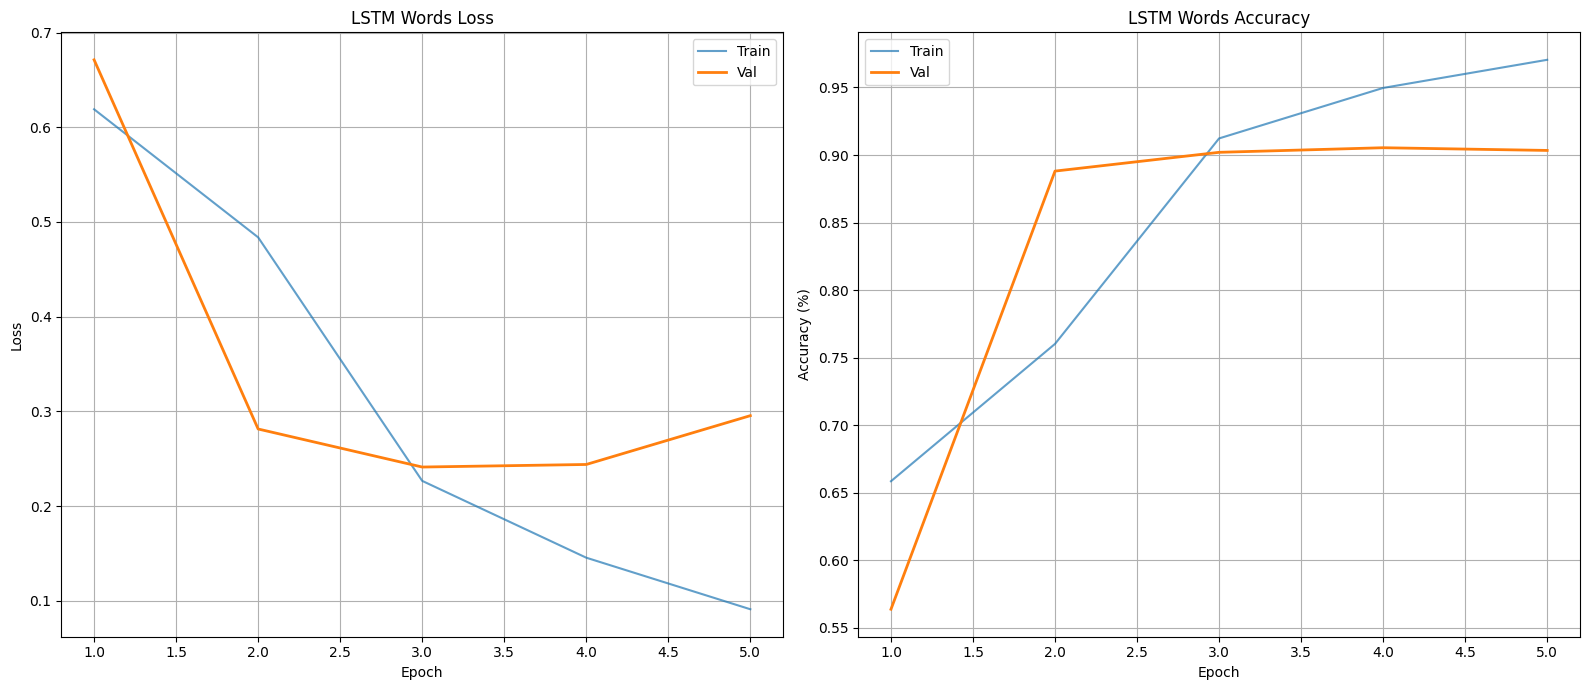

In [17]:
fig, axes= plt.subplots(1, 2, figsize= (16, 7))

axes[0].plot(history['epochs'], history['train_losses'], label= 'Train', alpha= 0.7)
axes[0].plot(history['epochs'], history['val_losses'], label= 'Val', linewidth= 2)
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LSTM Words Loss')
axes[0].legend()

axes[1].plot(history['epochs'], history['train_accuracies'], label= 'Train', alpha= 0.7)
axes[1].plot(history['epochs'], history['val_accuracies'], label= 'Val', linewidth= 2)
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('LSTM Words Accuracy')
axes[1].legend()


plt.tight_layout()
plt.show()

In [18]:
torch.save(model.state_dict(), artifacts_dir+"LSTM_BPE.pth")

In [21]:
def predict_sentiment_bpe(review_text, model, tokenizer, device, max_length=512):
    """
    Predict sentiment for a single review using BPE tokenization
    """
    # Clean the text (using your clean_text function)
    cleaned_text = clean_text(review_text)

    # Tokenize with BPE
    encoding = tokenizer.encode(cleaned_text)

    # Get token IDs and attention mask
    input_ids = encoding.ids
    attention_mask = [1] * len(input_ids)

    # Truncate if necessary
    if len(input_ids) > max_length:
        input_ids = input_ids[:max_length]
        attention_mask = attention_mask[:max_length]

    # Pad if necessary
    padding_length = max_length - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + [tokenizer.token_to_id("[PAD]")] * padding_length
        attention_mask = attention_mask + [0] * padding_length

    # Convert to tensors and add batch dimension
    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
    attention_tensor = torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor, attention_tensor)
        probability = torch.sigmoid(output).item()
        prediction = 1 if probability > 0.5 else 0

    return prediction, probability

In [31]:
review= """Just a sweet movie,

which is lovely, with beautiful decors. Doesnt deserve the hate it received.

Loved the animals and the songs. Gal Gadot is not great as queen. Rachel Zegler is good as always.

The dwarfs are funny, with good jokes and lots of gimmicks. The 'prince' is a bit too goofy.

His mixed band of merry men does not add much. The end scene was nice, could have been a bit longer.

All together I really enjoyed it and can recommend it to many audiences of all ages.

Go Watch out in the cinema, where the beautiful backgrounds will be extra great. A modern fairytale.

The makers should be proud and ignore the haters."""

prediction, confidence = predict_sentiment_bpe(review, model, bpe_tokenizer, device)
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Review : {review}")
print(f"Sentiment: {sentiment} (Confidence: {confidence:.4f})")

Review : Just a sweet movie, 

which is lovely, with beautiful decors. Doesnt deserve the hate it received.

Loved the animals and the songs. Gal Gadot is not great as queen. Rachel Zegler is good as always.

The dwarfs are funny, with good jokes and lots of gimmicks. The 'prince' is a bit too goofy.

His mixed band of merry men does not add much. The end scene was nice, could have been a bit longer. 

All together I really enjoyed it and can recommend it to many audiences of all ages. 

Go Watch out in the cinema, where the beautiful backgrounds will be extra great. A modern fairytale. 

The makers should be proud and ignore the haters.
Sentiment: Positive (Confidence: 0.9987)
